In [6]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors, patches
from tqdm.notebook import tqdm
import colorcet as cc

In [7]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

### Massive type IIA on $S^3\times S^3$

Scanning over the parameters ($u_0,\phi_0$) shows which values are potentially viable for fixed $q_0$:

100%|██████████| 900/900 [00:38<00:00, 23.65it/s]


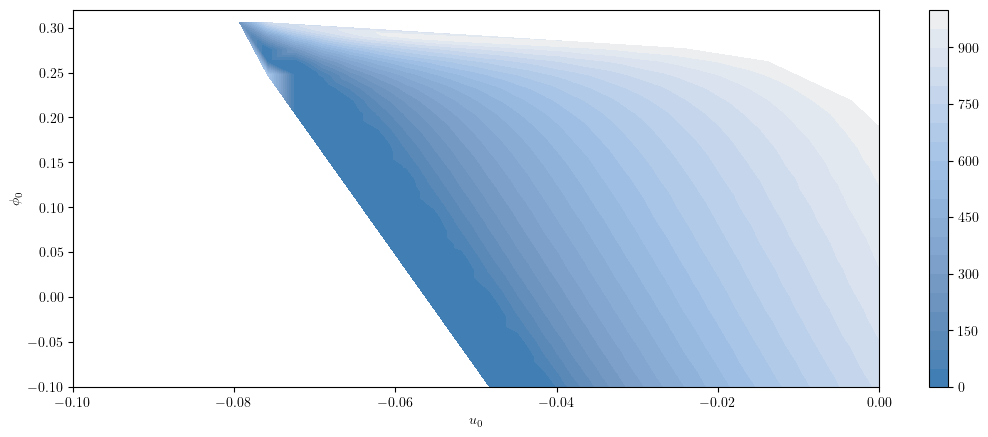

In [10]:
wh.paramScan_S3S3(1, 10, [-0.1, 0], [-0.1, 0.32], 30, 30)

Example profiles upon picking ($u_0,\phi_0$) by hand:

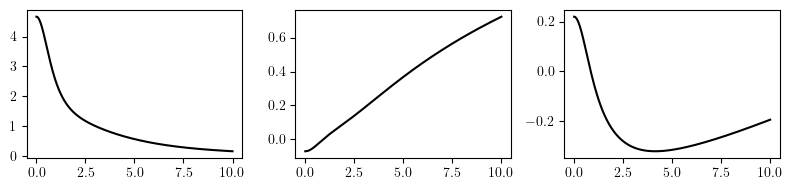

In [11]:
q0, rmax = 1, 10
u0, φ0 = -0.07, 0.22
soln = wh.solve_S3S3(q0, rmax, u0, φ0)
r, w, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(r, w, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).


Performing shooting method for q0 = 1 out to r = 10 ...
  rmax = 1.0000 with xatol = 0.0001
    f_eval : 98
        u0 : -0.07570750404
        φ0 : +0.2679907332
       val : 1.081073975e-08
  rmax = 3.1623 with xatol = 0.0001
    f_eval : 47
        u0 : -0.07891023104
        φ0 : +0.2942145175
       val : 5.952177662e-08
  rmax = 10.0000 with xatol = 1e-10
    f_eval : 136
        u0 : -0.0789187253
        φ0 : +0.2943215664
       val : 0


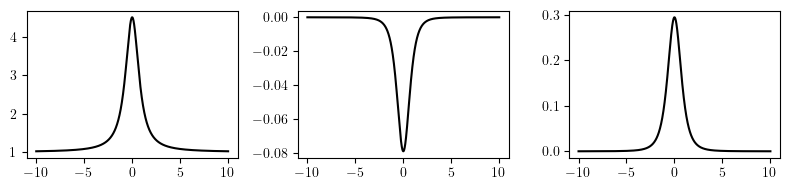

In [12]:
q0, rmax = 1, 10
soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-10)
r, w, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(r, w, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

More detailed plot of profiles:

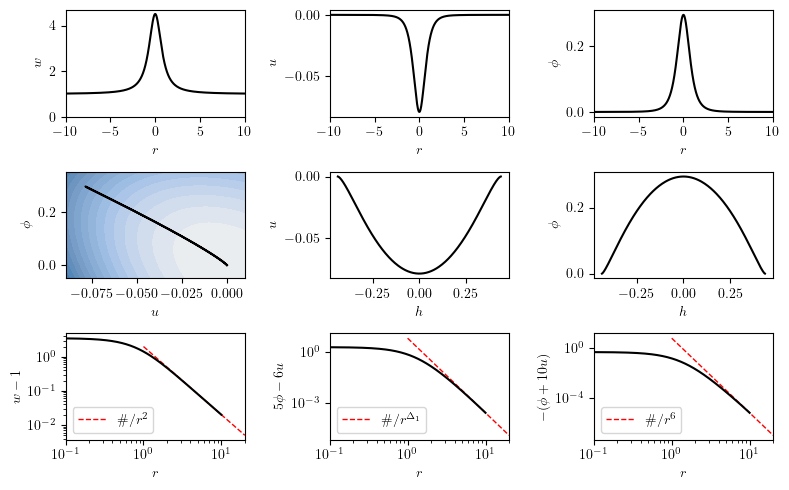

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(8,5))

xdata = [r, r, r, u, h, h, r,   r,       r        ]
ydata = [w, u, φ, φ, u, φ, w-1, 5*φ-6*u, -(φ+10*u)]
xlabels = ['$r$', '$r$', '$r$', '$u$', '$h$', '$h$', '$r$', '$r$', '$r$']
ylabels = ['$w$', '$u$', '$\phi$', '$\phi$', '$u$', '$\phi$', '$w-1$', '$5\phi-6u$', '$-(\phi+10u)$']


# Plot expected power-law fall-offs in asymptotic region
Δ1 = (3+np.sqrt(33))/2
wcoeff = np.mean(r[-10:]**2 * (w[-10:] - 1))
uφcoeff1 = np.mean(r[-10:]**Δ1 * (5*φ[-10:] - 6*u[-10:]))
uφcoeff2 = np.mean(r[-10:]**6 * (-φ[-10:] - 10*u[-10:]))

rr = np.linspace(q0, 2*rmax, 2)
axes[2,0].plot(rr, wcoeff/rr**2, '--r', lw=1, label='$\#/r^2$')
axes[2,1].plot(rr, uφcoeff1/rr**Δ1, '--r', lw=1, label='$\#/r^{\Delta_1}$')
axes[2,2].plot(rr, uφcoeff2/rr**6, '--r', lw=1, label='$\#/r^6$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

for ax in axes[0]:
    ax.set_xlim(-10, 10)
axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[1,0].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(φ0s[0], φ0s[-1])


for ax in axes[2]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Field ranges (with comparison to _ad hoc_ replacement $\mathcal{V}\to-6$ where $u,\phi$ are massless):

In [14]:
q0s = np.geomspace(0.001, 10, 5)

q0s_ml = np.geomspace(q0s[0], q0s[-1], 20)
data_ml = np.asarray([wh.massless_approx_S3S3(q0, 10*q0, q0/1000) for q0 in q0s_ml])
u0s_ml, φ0s_ml, f4s_ml = data_ml.T

data = []

for q0 in q0s:

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-8)
    r, w, u, ud, φ, φd, h, f4sqr = soln

    # It happens that u<0 and φ>0
    data.append([min(u), max(φ), np.sqrt(f4sqr)])

u0s, φ0s, f4s = np.asarray(data).T


Performing shooting method for q0 = 0.001 out to r = 10 ...
  rmax = 0.0010 with xatol = 0.0001
    f_eval : 118
        u0 : -0.2993062535
        φ0 : +0.6303910603
       val : 9.232943299e-10
  rmax = 0.1000 with xatol = 0.0001
    f_eval : 78
        u0 : -0.7814172552
        φ0 : +1.564225411
       val : 5.203197873e-10
  rmax = 10.0000 with xatol = 1e-08
    f_eval : 127
        u0 : -0.7815159636
        φ0 : +1.56445022
       val : 9.992007222e-15

Performing shooting method for q0 = 0.0074008280449228536 out to r = 10 ...
  rmax = 0.0074 with xatol = 0.0001
    f_eval : 121
        u0 : -0.2989804271
        φ0 : +0.6301777018
       val : 1.167017816e-09
  rmax = 0.2720 with xatol = 0.0001
    f_eval : 83
        u0 : -0.7310824313
        φ0 : +1.511151467
       val : 1.267679295e-09
  rmax = 10.0000 with xatol = 1e-08
    f_eval : 134
        u0 : -0.7313015979
        φ0 : +1.51198087
       val : 1.421085472e-14

Performing shooting method for q0 = 0.054772255750516

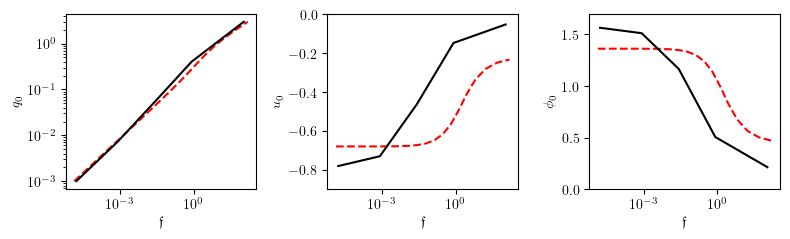

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(8,2.5))

axes[0].plot(f4s_ml, q0s_ml, '--r')
axes[0].plot(f4s, q0s, 'k', ms=3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\mathfrak{f}$')
axes[0].set_ylabel('$q_0$')

axes[1].plot(f4s_ml, u0s_ml, '--r')
axes[1].plot(f4s, u0s, 'k', ms=3)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\mathfrak{f}$')
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)


axes[2].plot(f4s_ml, φ0s_ml, '--r')
axes[2].plot(f4s, φ0s, 'k', ms=3)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\mathfrak{f}$')
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.tight_layout()
# plt.savefig('S3S3_ranges.png', dpi=300)
plt.show()

### Type IIB on $T^{1,1}$

Scanning over the parameters ($u_0,v_0$) shows which values are potentially viable for fixed $q_0$:

100%|██████████| 900/900 [02:46<00:00,  5.40it/s]


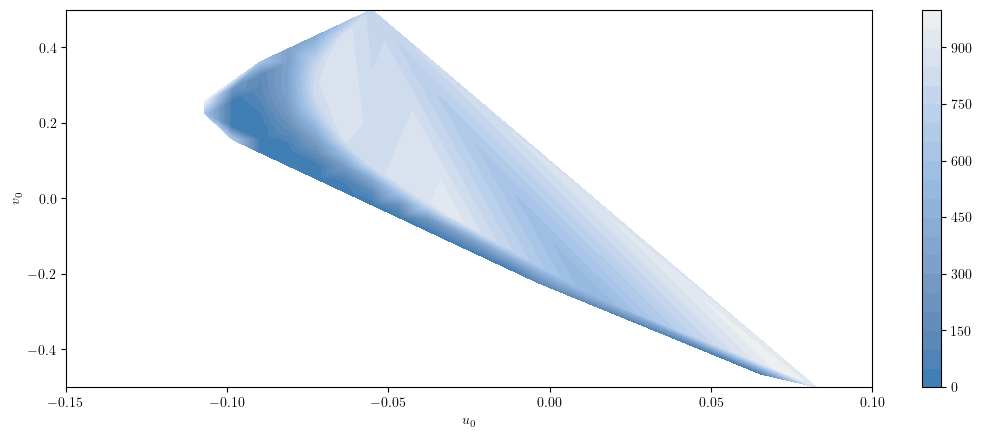

In [29]:
wh.paramScan_T11(1, 5, [-0.12, 0.08], [-0.5,0.5], 30, 30)

Example profiles upon picking ($u_0,v_0$) by hand (wlg, $\phi_0=0$):

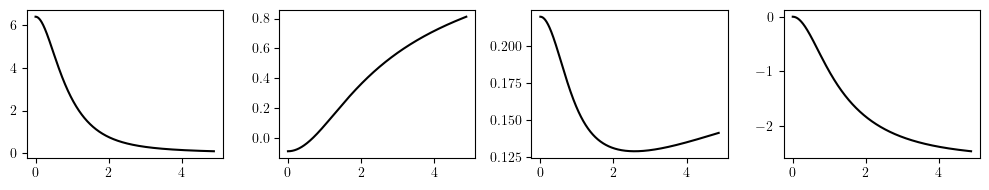

In [33]:
q0, rmax = 1, 5
u0, v0 = -0.09, 0.2
soln = wh.solve_T11(q0, rmax, u0, φ0, 0)
r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

fig, axes = plt.subplots(1, 4, figsize=(10,2))

axes[0].plot(r, w, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, v, 'k')
axes[3].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).


Performing shooting method for q0 = 1 out to r = 10 ...
  rmax = 1.0000 with xatol = 0.0001
    f_eval : 104
        u0 : -0.09957659666
        v0 : +0.1697326255
       val : 2.361437834e-08
  rmax = 3.1623 with xatol = 0.0001
    f_eval : 55
        u0 : -0.1030343401
        v0 : +0.1826934047
       val : 3.595214413e-07
  rmax = 10.0000 with xatol = 1e-12
    f_eval : 290
        u0 : -0.1030305483
        v0 : +0.182679173
       val : 0


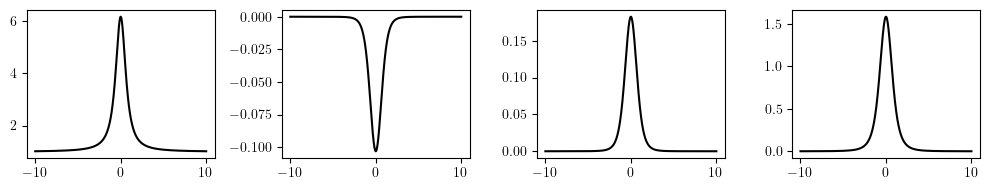

In [42]:
q0, rmax = 1, 10
soln = wh.wormhole_T11(q0, rmax, xatol=10**-12)
r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

fig, axes = plt.subplots(1, 4, figsize=(10,2))

axes[0].plot(r, w, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, v, 'k')
axes[3].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

More detailed plot of profiles:

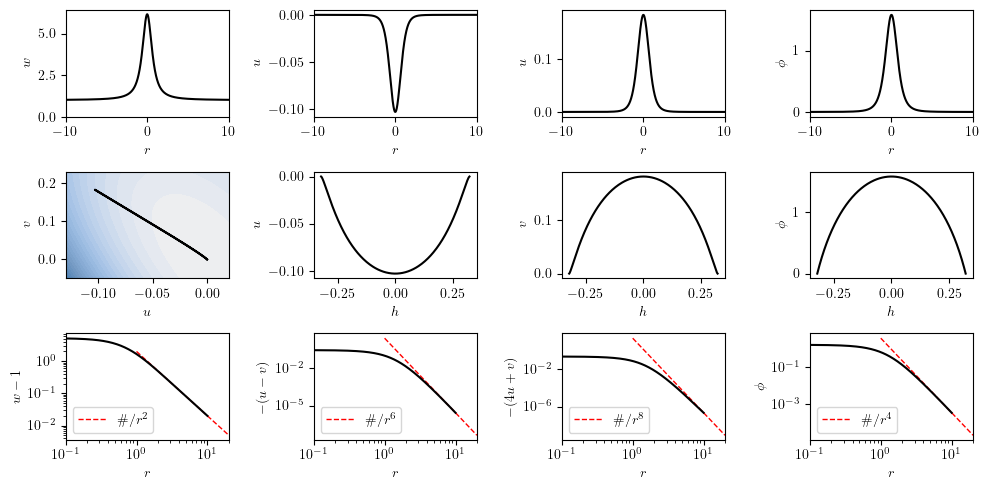

In [47]:
fig, axes = plt.subplots(3, 4, figsize=(10,5))

xdata = [r, r, r, r, u, h, h, h, r, r, r, r]
ydata = [w, u, v, φ, v, u, v, φ, w-1, -(u-v), -(4*u+v), φ]
xlabels = ['$r$', '$r$', '$r$', '$r$', '$u$', '$h$', '$h$', '$h$', '$r$', '$r$', '$r$', '$r$']
ylabels = ['$w$', '$u$', '$u$', '$\phi$', '$v$', '$u$', '$v$', '$\phi$', '$w-1$', '$-(u-v)$', '$-(4u+v)$', '$\phi$']


# # Plot expected power-law fall-offs in asymptotic region
wcoeff = np.mean(r[-10:]**2 * (w[-10:] - 1))
uvcoeff1 = np.mean(r[-10:]**6 * (-u[-10:] + v[-10:]))
uvcoeff2 = np.mean(r[-10:]**8 * (-4*u[-10:] - v[-10:]))
φcoeff = np.mean(r[-10:]**4 * φ[-10:])

rr = np.linspace(q0, 2*rmax, 2)
axes[2,0].plot(rr, wcoeff/rr**2, '--r', lw=1, label='$\#/r^2$')
axes[2,1].plot(rr, uvcoeff1/rr**6, '--r', lw=1, label='$\#/r^6$')
axes[2,2].plot(rr, uvcoeff2/rr**8, '--r', lw=1, label='$\#/r^8$')
axes[2,3].plot(rr, φcoeff/rr**4, '--r', lw=1, label='$\#/r^4$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

for ax in axes[0]:
    ax.set_xlim(-10, 10)
axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.13, 0.02, 40)
v0s = np.linspace(-0.05, 0.23, 40)
umesh, vmesh = np.meshgrid(u0s, v0s)
VV = wh.V_T11(umesh, vmesh)

axes[1,0].contourf(umesh, vmesh, VV,
                   levels=np.arange(-12, 1, 0.5),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], v0s[0], v0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(v0s[0], v0s[-1])


for ax in axes[2]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Field ranges (with comparison to _ad hoc_ changes to the potential where $u,v$ are frozen or massless):

In [113]:
q0s = np.geomspace(0.1, 10, 5)

q0s_ml = np.geomspace(0.7728, q0s[-1], 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0s_ml, v0s_ml, φ0s_ml, f3s_ml = data_ml.T

q0s_fr = np.geomspace(q0s[0], q0s[-1], 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0s_fr, v0s_fr, φ0s_fr, f3s_fr = data_fr.T

data = []

for q0 in q0s:

    rmax = max(10, 10*q0)
    soln = wh.wormhole_T11(q0, rmax, xatol=10**-8)
    r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

    # It happens that u<0 and v,φ>0. Extract also the 1/r^4 coefficient in φ,
    #   computed two ways, for comparison with the BPS bound
    data.append([min(u), max(v), max(φ), np.sqrt(f3sqr),
                 np.mean(r[-10:]**4 * φ[-10:]),
                 np.mean(r[-10:]**5 * φd[-10:] / (-4))
                ])

u0s, v0s, φ0s, f3s, φ4s, φ4s_alt = np.asarray(data).T


Performing shooting method for q0 = 0.1 out to r = 10 ...
  rmax = 0.1000 with xatol = 0.0001
    f_eval : 112
        u0 : -0.3745292062
        v0 : +0.4563188723
       val : 1.644256509e-09
  rmax = 1.0000 with xatol = 0.0001
    f_eval : 122
        u0 : -0.4585074144
        v0 : +0.6698583039
       val : 3.184373999e-07
  rmax = 10.0000 with xatol = 1e-08
    f_eval : 169
        u0 : -0.4585076508
        v0 : +0.6698754813
       val : 2.039923785e-12

Performing shooting method for q0 = 0.31622776601683794 out to r = 10 ...
  rmax = 0.3162 with xatol = 0.0001
    f_eval : 112
        u0 : -0.2117509254
        v0 : +0.3112412579
       val : 3.949010896e-09
  rmax = 1.7783 with xatol = 0.0001
    f_eval : 67
        u0 : -0.2314063914
        v0 : +0.3771216966
       val : 4.078513463e-06
  rmax = 10.0000 with xatol = 1e-08
    f_eval : 146
        u0 : -0.231397102
        v0 : +0.3770755041
       val : 3.368860746e-12

Performing shooting method for q0 = 1.0 out to r = 

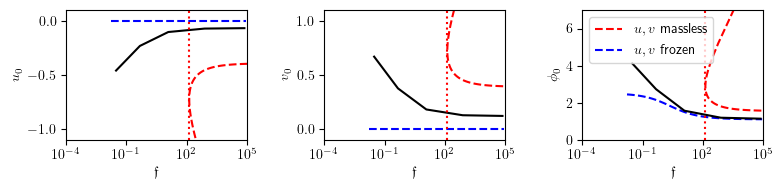

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(f3s_ml, u0s_ml, '--r')
axes[0].plot(f3s_fr, u0s_fr, '--b')
axes[0].plot(f3s, u0s, 'k')

axes[1].plot(f3s_ml, v0s_ml, '--r')
axes[1].plot(f3s_fr, v0s_fr, '--b')
axes[1].plot(f3s, v0s, 'k')

axes[2].plot(f3s_ml, φ0s_ml, '--r', label='$u,v$ massless')
axes[2].plot(f3s_fr, φ0s_fr, '--b', label='$u,v$ frozen')
axes[2].plot(f3s, φ0s, 'k')

for ax, ylab in zip(axes, ['$u_0$', '$v_0$', '$\phi_0$']):
    ax.axvline(min(f3s_ml), ls=':', c='r')
    ax.set_xlim(10**-4, 10**5)
    ax.set_xscale('log')
    ax.set_xlabel('$\mathfrak{f}$')
    ax.set_ylabel(ylab)

axes[0].set_ylim(-1.1, 0.1)
axes[1].set_ylim(-0.1, 1.1)
axes[2].set_ylim(0, 7)

axes[2].legend()

plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)
# plt.savefig('T11_ranges.png', dpi=300)
plt.show()

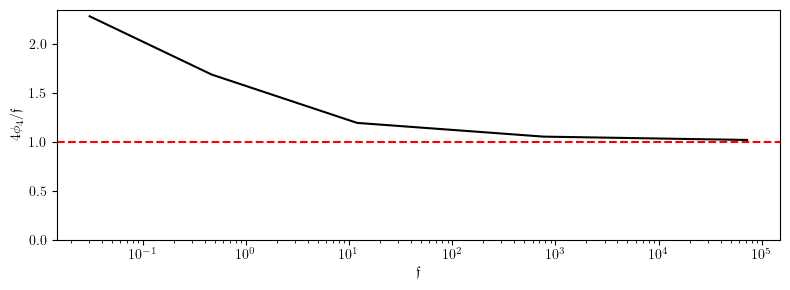

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))

plt.axhline(1, ls='--', c='r')

plt.plot(f3s, 4*φ4s/f3s, 'k')
# plt.plot(f3s, 4*φ4s_alt/f3s, 'b')

# plt.xlim(10**-3.75, 10**4.5)
plt.ylim(0)

plt.xscale('log')
plt.xlabel('$\mathfrak{f}$')
plt.ylabel('$4\phi_4/\mathfrak{f}$')

plt.tight_layout()
# plt.savefig('T11_BPS.png', dpi=300)
plt.show()